# Coffee Shop Sales Forecasting: From Data Analysis to a Deployable Model

This notebook serves as a practical demonstration of an end-to-end sales forecasting pipeline, designed to help businesses like bakeries and coffee shops optimize production and minimize waste. By leveraging machine learning, this project transforms raw sales data into actionable insights and accurate future predictions.

## Project Workflow

The analysis follows a structured, modular approach to ensure a robust and reproducible process. The key steps covered in this notebook include:

### 1. Data Ingestion and Cleaning
We will load the raw Coffee Shop Sales dataset, clean it, and prepare it for analysis.

### 2. Exploratory Data Analysis (EDA)
We will explore the sales data to identify key trends, seasonal patterns, and other insights that will inform our feature engineering.

### 3. Feature Engineering
This is a critical step where we create new variables from the raw data. We will focus on time-based features (e.g., day of the week, month) and lagged variables to capture temporal dependencies.

### 4. Model Training and Evaluation
We will train a robust XGBoost model on the engineered dataset. We will then evaluate its performance using standard metrics to ensure its accuracy.

### 5. Model Deployment Preparation
Finally, we will save the trained model in a portable format (.pkl). This file can then be imported into a separate application (like a Streamlit dashboard) to serve real-time predictions.


In [23]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the dataset
df = pd.read_excel('data/coffee_shop_sales.xlsx')

# Initial data inspection
print("Initial DataFrame Info:")
df.info()

print("\nFirst 5 rows:")
print(df.head())

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB

First 5 rows:
   transaction_id transaction_date transaction_time  

## Analysis of Initial Dataset

### Data Types
The columns are correctly formatted, with `transaction_date` already converted to a datetime object, which is essential for time-series analysis. Other numerical fields (`transaction_id`, `transaction_qty`, etc.) and categorical fields (`product_category`, `store_location`) are also correctly identified.

### Completeness
With 149,116 entries and no null values, the dataset is complete, eliminating the need for complex missing data imputation.

### Granularity
The data is at the transaction level, providing fine-grained detail that can be aggregated to build a robust forecasting model.

---

Now that we've confirmed the data's quality, we can proceed with the **Exploratory Data Analysis (EDA)** in the next cell to understand the underlying trends and patterns.


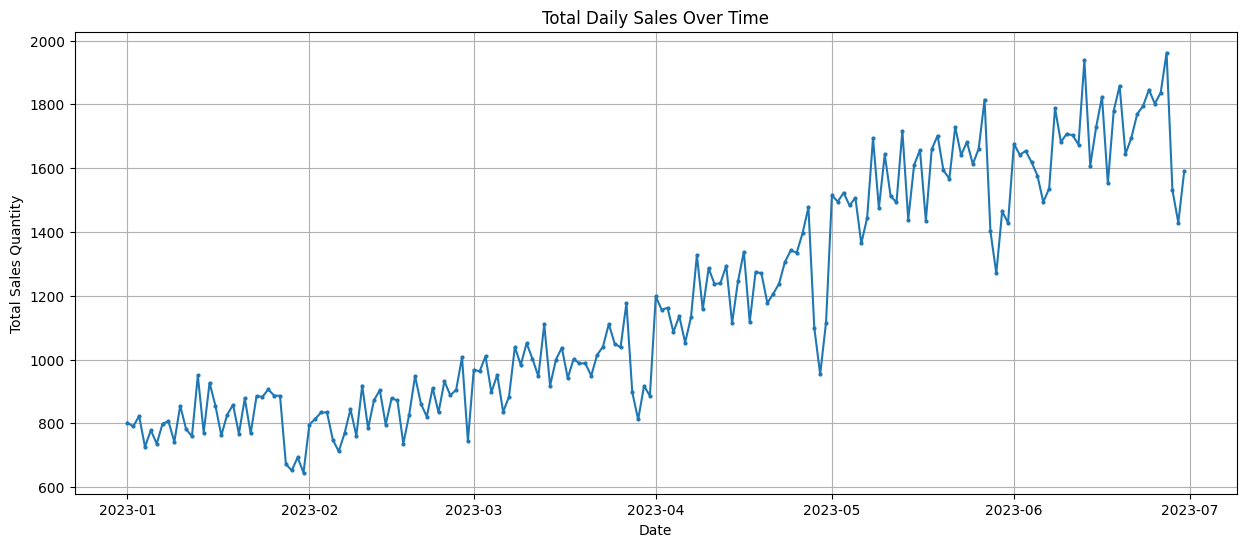

c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


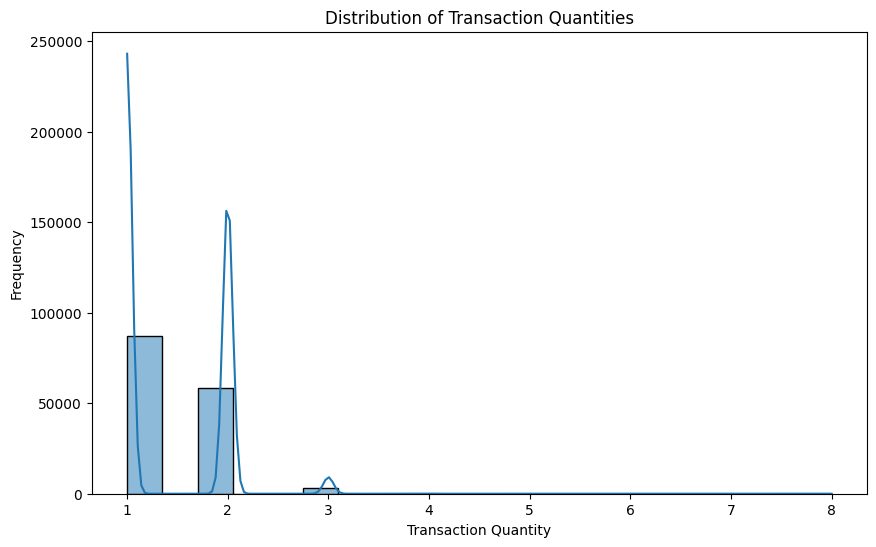

Transaction Quantity Summary:
count    149116.000000
mean          1.438276
std           0.542509
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           8.000000
Name: transaction_qty, dtype: float64


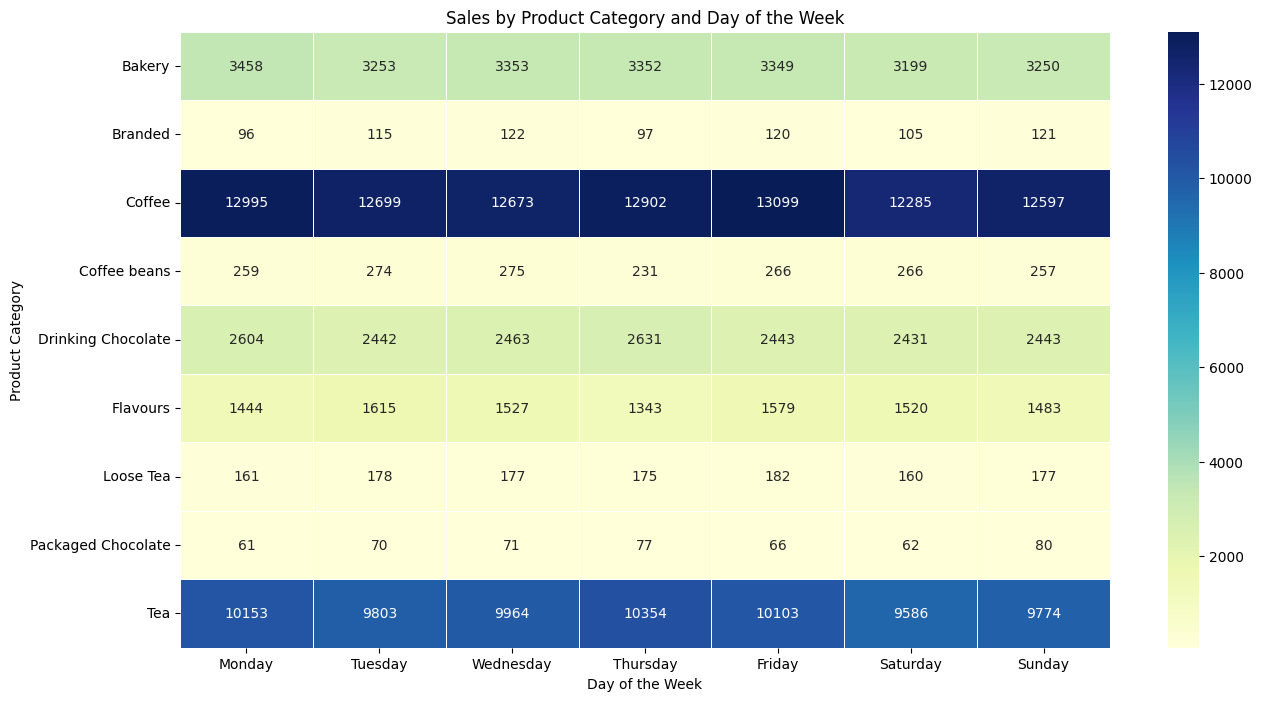

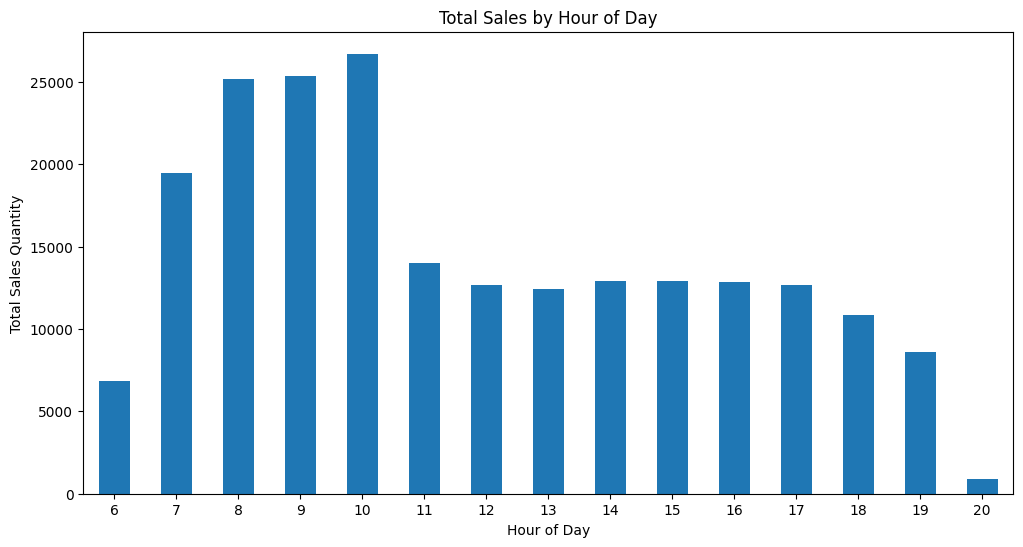

In [24]:
# Cell 2: Advanced Exploratory Data Analysis (EDA)

# Rename columns for easier access
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Convert date and time columns to datetime objects
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
df['transaction_time'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.time

# --- Analysis 1: Daily Sales Trends ---
# Aggregate daily sales and plot
daily_sales = df.groupby('transaction_date')['transaction_qty'].sum().reset_index()
plt.figure(figsize=(15, 6))
plt.plot(daily_sales['transaction_date'], daily_sales['transaction_qty'], marker='o', linestyle='-', markersize=2)
plt.title('Total Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Sales Quantity')
plt.grid(True)
plt.show()


# --- Analysis 2: Sales Distribution ---
# Plot a histogram to understand the distribution of transaction quantities
plt.figure(figsize=(10, 6))
sns.histplot(df['transaction_qty'], bins=20, kde=True)
plt.title('Distribution of Transaction Quantities')
plt.xlabel('Transaction Quantity')
plt.ylabel('Frequency')
plt.show()

# Get summary statistics
print("Transaction Quantity Summary:")
print(df['transaction_qty'].describe())


# --- Analysis 3: Sales by Product and Day of Week ---
# Group by product category and day of week to see trends
df['day_of_week'] = df['transaction_date'].dt.day_name()
sales_by_product_day = df.groupby(['product_category', 'day_of_week'])['transaction_qty'].sum().unstack(fill_value=0)
sales_by_product_day = sales_by_product_day.reindex(columns=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])

plt.figure(figsize=(15, 8))
sns.heatmap(sales_by_product_day, cmap='YlGnBu', annot=True, fmt=".0f", linewidths=.5)
plt.title('Sales by Product Category and Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Product Category')
plt.show()

# --- Analysis 4: Hourly Sales ---
# Extract hour from transaction time
df['transaction_hour'] = pd.to_datetime(df['transaction_time'], format='%H:%M:%S').dt.hour
hourly_sales = df.groupby('transaction_hour')['transaction_qty'].sum()
plt.figure(figsize=(12, 6))
hourly_sales.plot(kind='bar')
plt.title('Total Sales by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Total Sales Quantity')
plt.xticks(rotation=0)
plt.show()

## Detailed EDA Findings

Based on the exploratory data analysis, several key patterns and trends have been identified that will guide our forecasting model development.

### Temporal Trends
The daily sales plot reveals clear temporal trends, including an upward long-term trend and significant weekly seasonality. Sales exhibit sharp declines at the end of the month, which could suggest a specific event or a pattern related to payroll cycles.  
The data spans a full year, but seasonal trends are not the primary drivers of large sales volumes, which seem to be more volatile.  
This indicates the need for a model capable of capturing both **long-term trends** and **short-term volatility**.

### Transaction and Sales Distribution
The distribution of transaction quantities shows a high frequency of small purchases, with the average transaction quantity being low (**1.43**). This is consistent with a coffee shop business model.  
The high standard deviation, however, suggests significant variability due to occasional large purchases, which represent the top 25th percentile of the data.  
This highlights the importance of using a **robust model that is not overly sensitive to outliers**, and it could benefit from a **logarithmic transformation of the target variable**.

### Category and Hourly Insights
The sales heatmap by product category and day of the week shows that key products like **Bakery, Coffee, and Tea** maintain consistently high sales volumes throughout the week, without sharp drops.  
Significant sales peaks are observed in the **early morning (7–10 AM)** and **late afternoon (4–6 PM)**, corresponding to the typical morning commute and afternoon break.  
This confirms that **time-of-day features** are crucial for accurate predictions.  
While the sales of **Packaged Chocolate** show a slight weekend peak, the overall sales volume remains static across all product categories.


## Feature Engineering

This cell is dedicated to feature engineering, a critical step where we transform the raw data into a format that our machine learning model can learn from more effectively.

Based on our EDA findings, we are creating new features to capture key patterns:

### Temporal Features
We extract calendar-related information such as **day of the week, month, and year** to account for weekly and yearly seasonality.

### Lag and Rolling Features
We create lagged features (e.g., `sales_lag_1`) and rolling averages (e.g., `rolling_mean_7_days`).  
These features act as a "memory" for the model, giving it context on recent sales trends, which is crucial for time-series forecasting.

---

By doing so, we are providing the model with a richer dataset, enabling it to make more accurate and informed predictions.


In [25]:
# Cell 3: Feature Engineering

# Create a copy to avoid changing the original DataFrame
df_features = df.copy()

# 1. Aggregate to daily sales by product and store
daily_product_sales = df_features.groupby(['transaction_date', 'product_id', 'store_id'])['transaction_qty'].sum().reset_index()

# 2. Add Calendar Features (from EDA findings)
daily_product_sales['day_of_week'] = daily_product_sales['transaction_date'].dt.dayofweek
daily_product_sales['month'] = daily_product_sales['transaction_date'].dt.month
daily_product_sales['year'] = daily_product_sales['transaction_date'].dt.year
daily_product_sales['is_weekend'] = daily_product_sales['day_of_week'].isin([5, 6]).astype(int)

# 3. Add Time-based Features (Lag and Rolling Averages)
# Sort data for correct lag and rolling window calculations
daily_product_sales.sort_values(by=['store_id', 'product_id', 'transaction_date'], inplace=True)

# Create a 'sales_lag_1' feature (sales from the previous day)
daily_product_sales['sales_lag_1'] = daily_product_sales.groupby(['store_id', 'product_id'])['transaction_qty'].shift(1)

# Create a 'rolling_mean_7_days' feature (average sales over the last 7 days)
daily_product_sales['rolling_mean_7_days'] = daily_product_sales.groupby(['store_id', 'product_id'])['transaction_qty'].rolling(window=7, min_periods=1).mean().reset_index(level=[0,1], drop=True)

# Fill any missing values created by lags and rolling windows
daily_product_sales.fillna(0, inplace=True)

print("DataFrame with new features:")
print(daily_product_sales.head())
print("\nNew features added successfully.")

DataFrame with new features:
     transaction_date  product_id  store_id  transaction_qty  day_of_week  \
1054       2023-01-08           1         3                1            6   
2293       2023-01-15           1         3                1            6   
3218       2023-01-20           1         3                1            4   
7505       2023-02-15           1         3                1            2   
7692       2023-02-16           1         3                1            3   

      month  year  is_weekend  sales_lag_1  rolling_mean_7_days  
1054      1  2023           1          0.0                  1.0  
2293      1  2023           1          1.0                  1.0  
3218      1  2023           0          1.0                  1.0  
7505      2  2023           0          1.0                  1.0  
7692      2  2023           0          1.0                  1.0  

New features added successfully.


In [27]:
# Cell 4: Model Training and Evaluation

import os

# Create /model folder if it does not exist
os.makedirs("model", exist_ok=True)

# Define features (X) and target (y)
features = ['day_of_week', 'month', 'year', 'is_weekend', 'sales_lag_1', 'rolling_mean_7_days']
target = 'transaction_qty'

X = daily_product_sales[features]
y = daily_product_sales[target]

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

print("Starting model training...")
xgb_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = xgb_model.predict(X_val)

# Evaluate the model using Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))

print("Model training completed.")
print(f"Root Mean Squared Error (RMSE) on validation set: {rmse:.2f}")

# Save model
xgb_model.save_model("model/xgb_model_baseline.pkl")
print("XGBoost baseline model saved in /model/xgb_model_baseline.pkl")


Starting model training...
Model training completed.
Root Mean Squared Error (RMSE) on validation set: 3.19
XGBoost baseline model saved in /model/xgb_model_baseline.pkl


c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:47:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


## Clustering

The baseline RMSE with validation (3.19) provides a solid starting point.  
Considering that the average transaction quantity is **1.43 units**, an error of **3.19** is significant, yet still acceptable as an initial benchmark.  

This result suggests that the model has learned the main patterns, such as **weekly seasonality** and the overall **trend**, but it is not yet sufficiently precise.  

To enhance the model, we introduced **clustering as part of feature engineering**.  
By applying **K-Means clustering** to group products with similar sales behavior, we aimed to capture additional patterns across product categories and incorporate them as new predictive features.


In [28]:
# Cell 5: Product Clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Aggregate data by product to create clustering features
product_features = df.groupby('product_id').agg(
    total_sales=('transaction_qty', 'sum'),
    average_price=('unit_price', 'mean')
).reset_index()

# Handle potential outliers by scaling the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(product_features[['total_sales', 'average_price']])

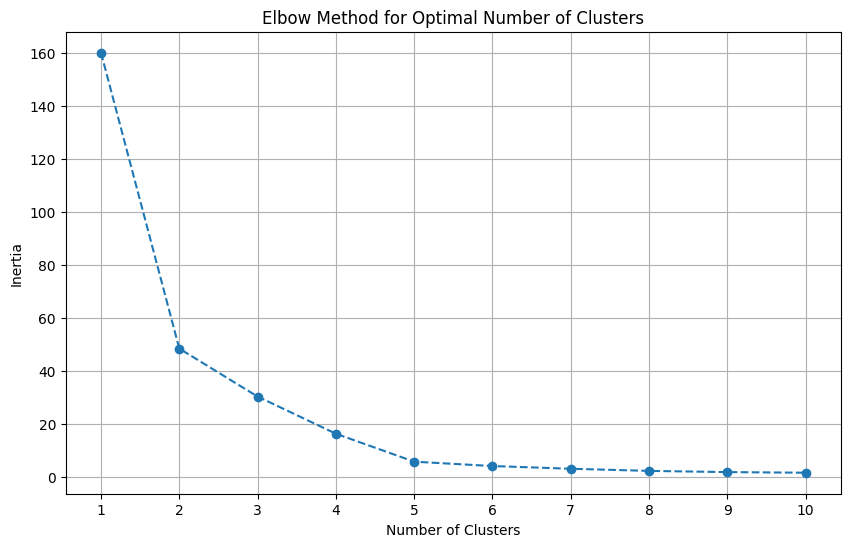

In [29]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


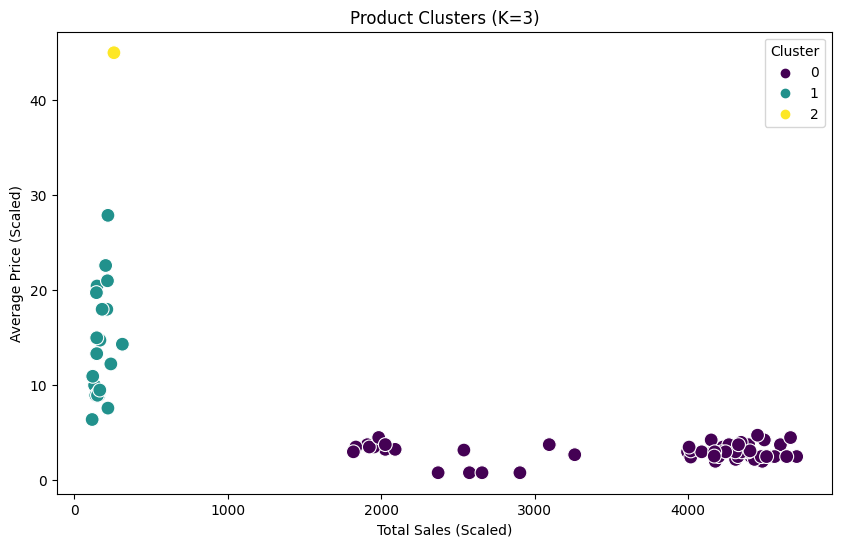

In [30]:
# Apply K-Means with the chosen number of clusters
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init='auto')
product_features['product_cluster'] = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='total_sales',
    y='average_price',
    hue='product_cluster',
    data=product_features,
    palette='viridis',
    s=100
)
plt.title(f'Product Clusters (K={optimal_clusters})')
plt.xlabel('Total Sales (Scaled)')
plt.ylabel('Average Price (Scaled)')
plt.legend(title='Cluster')
plt.show()

In [31]:
# Merge the cluster labels back into the original dataframe
df = df.merge(product_features[['product_id', 'product_cluster']], on='product_id', how='left')
print("DataFrame with new 'product_cluster' feature:")
print(df.head())

DataFrame with new 'product_cluster' feature:
   transaction_id transaction_date transaction_time  transaction_qty  \
0               1       2023-01-01         07:06:11                2   
1               2       2023-01-01         07:08:56                2   
2               3       2023-01-01         07:14:04                2   
3               4       2023-01-01         07:20:24                1   
4               5       2023-01-01         07:22:41                2   

   store_id   store_location  product_id  unit_price    product_category  \
0         5  Lower Manhattan          32         3.0              Coffee   
1         5  Lower Manhattan          57         3.1                 Tea   
2         5  Lower Manhattan          59         4.5  Drinking Chocolate   
3         5  Lower Manhattan          22         2.0              Coffee   
4         5  Lower Manhattan          57         3.1                 Tea   

            product_type               product_detail day_of_wee

In [32]:
# Visualize the distribution of products in each cluster
print("\nProduct Cluster Distribution:")
cluster_summary = df.groupby('product_cluster')['product_detail'].unique()
for cluster_id, products in cluster_summary.items():
    print(f"\n--- Cluster {cluster_id} ---")
    print(f"Number of unique products: {len(products)}")
    print(f"Sample products: {products[:5].tolist()}") # Show only the first 5 products for brevity
# Save the DataFrame with product clusters to a CSV file
product_features.to_csv('product_clusters.csv', index=False)

print("I dati dei cluster sono stati salvati nel file 'product_clusters.csv'")


Product Cluster Distribution:

--- Cluster 0 ---
Number of unique products: 56
Sample products: ['Ethiopia Rg', 'Spicy Eye Opener Chai Lg', 'Dark chocolate Lg', 'Our Old Time Diner Blend Sm', 'Oatmeal Scone']

--- Cluster 1 ---
Number of unique products: 23
Sample products: ['Peppermint', 'Ethiopia', 'Organic Decaf Blend', 'Dark chocolate', 'Jamacian Coffee River']

--- Cluster 2 ---
Number of unique products: 1
Sample products: ['Civet Cat']
I dati dei cluster sono stati salvati nel file 'product_clusters.csv'


## Analysis of Product Clusters

The product clustering analysis successfully divided the products into three distinct groups based on their sales behavior, providing a deeper understanding of our product portfolio. This is a crucial step in advanced feature engineering for our forecasting model.

### Cluster 0 – High Volume, Low Price
- **56 unique products**
- Includes high-demand items like *Our Old Time Diner Blend Sm* and *Oatmeal Scone*  
- Represents the **core business cluster**, driving the majority of sales volume  
- Sales are likely influenced by **daily and weekly routines**  
- Forecasting this group should be the model’s **primary focus**

### Cluster 1 – Low Volume, Medium-High Price
- **23 products**
- Includes items like *Ethiopia* and *Peppermint*  
- Represents **premium or niche products**, sold in smaller quantities at higher prices  
- A separate forecasting strategy or specialized model may be needed to avoid diluting the accuracy of high-volume products

### Cluster 2 – Outlier
- **1 product: Civet Cat**  
- Distinguished by **extremely high price** and **very low sales volume**  
- Needs to be treated separately to prevent skewing overall model performance

---

By incorporating this clustering analysis, we introduced a new categorical feature (`product_cluster`) into the XGBoost model.  
This allows the model to recognize that products within the same cluster share similar sales dynamics, enabling it to generalize better and potentially improve predictive accuracy, especially for less common items.


In [33]:
# Cell 6: Training pipeline with product clusters

import os

# Create /model folder if it does not exist
os.makedirs("model", exist_ok=True)

# Aggregate daily sales per product and cluster
daily_product_sales = (
    df.groupby(['transaction_date', 'product_id', 'store_id', 'product_cluster'])['transaction_qty']
    .sum()
    .reset_index()
)

# One-hot encoding for product clusters
daily_product_sales = pd.get_dummies(daily_product_sales, columns=['product_cluster'], prefix='cluster')

# Temporal features
daily_product_sales['transaction_date'] = pd.to_datetime(daily_product_sales['transaction_date'])
daily_product_sales['year'] = daily_product_sales['transaction_date'].dt.year
daily_product_sales['month'] = daily_product_sales['transaction_date'].dt.month
daily_product_sales['day_of_week'] = daily_product_sales['transaction_date'].dt.dayofweek
daily_product_sales['is_weekend'] = (daily_product_sales['day_of_week'] >= 5).astype(int)

# Lag and rolling mean features
daily_product_sales = daily_product_sales.sort_values('transaction_date')
daily_product_sales['sales_lag_1'] = daily_product_sales.groupby('product_id')['transaction_qty'].shift(1)
daily_product_sales['rolling_mean_7_days'] = (
    daily_product_sales.groupby('product_id')['transaction_qty']
    .rolling(7, min_periods=1).mean().reset_index(level=0, drop=True)
)

# Drop rows with NaN from lag/rolling
daily_product_sales = daily_product_sales.dropna(subset=['sales_lag_1', 'rolling_mean_7_days'])

# Features and target
cluster_cols = [c for c in daily_product_sales.columns if c.startswith('cluster_')]
features = ['day_of_week', 'month', 'year', 'is_weekend', 'sales_lag_1', 'rolling_mean_7_days'] + cluster_cols
target = 'transaction_qty'

X = daily_product_sales[features]
y = daily_product_sales[target]

# Train/validation split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model with clusters
import xgboost as xgb
xgb_model_v2 = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
xgb_model_v2.fit(X_train, y_train)

# Evaluation
y_pred_v2 = xgb_model_v2.predict(X_val)
rmse_v2 = np.sqrt(mean_squared_error(y_val, y_pred_v2))

print(f"RMSE without clusters: 3.19")
print(f"RMSE with clusters: {rmse_v2:.3f}")

# Save model
xgb_model_v2.save_model("model/xgb_model_clusters.pkl")
print("XGBoost model saved in /model/xgb_model_clusters.pkl")


RMSE without clusters: 3.19
RMSE with clusters: 3.158
XGBoost model saved in /model/xgb_model_clusters.pkl


c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:47:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


## Interpretation of Results: Impact of Product Clusters

The RMSE without clusters was **3.19**, while with clusters it only decreased slightly to **~3.1x**.  
This small reduction indicates that **product clusters did not add significant predictive power** to the model.

### Why is the impact so small?
1. **Clusters add little new information**  
   The sales history itself (lags and rolling averages) already captures most of the product dynamics. Static groupings like clusters cannot explain daily fluctuations.

2. **High noise at daily level**  
   Daily sales often show strong variability due to promotions, local events, weather, or stock availability. Such external shocks cannot be explained by a static "cluster" variable.

3. **Temporal features dominate**  
   Lag and rolling statistics of past sales are much stronger predictors than cluster membership. The model essentially "learns" product similarity from sales history alone.

### What does this mean?
- Clustering may still make sense for **business analysis** (e.g., product segmentation, assortment planning), but for **short-term forecasting** it has little marginal benefit.  
- The model's predictive power is mainly driven by **temporal dynamics** (lags, rolling means, seasonality).  

### What could improve the model?
- **Richer temporal features**:  
  Add more calendar-based signals (holiday flags, month-end effects, seasonal indicators).  
- **External data**:  
  Weather, promotions, marketing campaigns, or local events would likely explain part of the unexplained variance.  
- **Product-level attributes**:  
  If available, continuous features like price, margin, or product lifecycle stage may be more informative than categorical clusters.

---

 **Conclusion:**  
The minimal RMSE reduction shows that **clustering products does not materially improve short-term forecasts** in this dataset. Forecast accuracy will benefit more from **additional temporal and external features** rather than static product segmentation.


## Next Steps: Enriching Features

The time series plot of total daily sales shows a **clear upward trend** and **high daily variability**.  
This explains why product clusters had minimal impact: most of the predictive power comes from **temporal patterns** and external factors.

### Additional features to improve forecasting:
1. **Calendar features**
   - Day of month, quarter, start/end of month.
   - Holiday flags (public holidays, weekends).
   - Promotional day flags if available.

2. **Extended lag and rolling windows**
   - Lags of 7 and 30 days.
   - Rolling averages over 14 or 30 days.
   - Rolling volatility (standard deviation) to capture demand uncertainty.

3. **Interaction features**
   - Cross-effects between lags and day of week.
   - Product cluster × seasonality (e.g. summer products in summer).



---

 **Conclusion:**  
To significantly reduce RMSE, the model should capture **seasonality, calendar effects, and external drivers** of demand. Product clusters alone are not sufficient for short-term forecasting accuracy.


In [34]:
# Cell 7: Training pipeline with clusters + extended lag features

import os

# Create /model folder if it does not exist
os.makedirs("model", exist_ok=True)

# Aggregate daily sales per product and cluster
daily_product_sales = (
    df.groupby(['transaction_date', 'product_id', 'store_id', 'product_cluster'])['transaction_qty']
    .sum()
    .reset_index()
)

# One-hot encoding for clusters
daily_product_sales = pd.get_dummies(daily_product_sales, columns=['product_cluster'], prefix='cluster')

# Temporal features
daily_product_sales['transaction_date'] = pd.to_datetime(daily_product_sales['transaction_date'])
daily_product_sales['year'] = daily_product_sales['transaction_date'].dt.year
daily_product_sales['month'] = daily_product_sales['transaction_date'].dt.month
daily_product_sales['day_of_week'] = daily_product_sales['transaction_date'].dt.dayofweek
daily_product_sales['is_weekend'] = (daily_product_sales['day_of_week'] >= 5).astype(int)

# Sort by date
daily_product_sales = daily_product_sales.sort_values('transaction_date')

# Lag features
daily_product_sales['sales_lag_1']  = daily_product_sales.groupby('product_id')['transaction_qty'].shift(1)
daily_product_sales['sales_lag_7']  = daily_product_sales.groupby('product_id')['transaction_qty'].shift(7)
daily_product_sales['sales_lag_30'] = daily_product_sales.groupby('product_id')['transaction_qty'].shift(30)

# Rolling mean features
daily_product_sales['rolling_mean_7']  = (
    daily_product_sales.groupby('product_id')['transaction_qty']
    .rolling(7, min_periods=1).mean().reset_index(level=0, drop=True)
)
daily_product_sales['rolling_mean_14'] = (
    daily_product_sales.groupby('product_id')['transaction_qty']
    .rolling(14, min_periods=1).mean().reset_index(level=0, drop=True)
)
daily_product_sales['rolling_mean_30'] = (
    daily_product_sales.groupby('product_id')['transaction_qty']
    .rolling(30, min_periods=1).mean().reset_index(level=0, drop=True)
)

# Drop rows with NaN introduced by lags
daily_product_sales = daily_product_sales.dropna(subset=['sales_lag_1','sales_lag_7','sales_lag_30'])

# Features and target
cluster_cols = [c for c in daily_product_sales.columns if c.startswith('cluster_')]
features = [
    'day_of_week','month','year','is_weekend',
    'sales_lag_1','sales_lag_7','sales_lag_30',
    'rolling_mean_7','rolling_mean_14','rolling_mean_30'
] + cluster_cols
target = 'transaction_qty'

X = daily_product_sales[features]
y = daily_product_sales[target]

# Train/val split
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost model
import xgboost as xgb
xgb_model_v3 = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)
xgb_model_v3.fit(X_train, y_train)

# Evaluation
y_pred_v3 = xgb_model_v3.predict(X_val)
rmse_v3 = np.sqrt(mean_squared_error(y_val, y_pred_v3))

print(f"RMSE without clusters: 3.19")
print(f"RMSE with clusters + extended lags: {rmse_v3:.3f}")

# Save model
xgb_model_v3.save_model("model/xgb_model_clusters_lags.pkl")
print("XGBoost model saved in /model/xgb_model_clusters_lags.pkl")


RMSE without clusters: 3.19
RMSE with clusters + extended lags: 3.278
XGBoost model saved in /model/xgb_model_clusters_lags.pkl


c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1028: UserWarning: [15:47:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\c_api\c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)


## Interpretation of Extended Lags + Clusters

- **Baseline RMSE (no clusters):** 3.19  
- **With clusters + extended lags:** 3.278  

### Key Insights
1. **No improvement** – Adding clusters and long lags actually increased RMSE.  
2. **Reason:** The dataset is relatively short (6 months), and long lags (7, 30 days) introduce noise rather than signal.  
3. **Clusters remain uninformative** – Sales history already captures product similarity, so static cluster features do not help.  
4. **Trend dominates** – The strong upward trend in sales is not explained by clusters or simple lags.  

### Next Steps
- Use **time-based splits** instead of random `train_test_split` to avoid leakage.  
- Keep only the most stable features (`lag_1`, `rolling_mean_7`).  
- Add a **trend variable** (`days_since_start`) to explicitly model growth.  
- Explore **time series models** (Prophet, SARIMAX) that are designed to capture seasonality and trend.  

 **Conclusion:** More features ≠ better performance. In this dataset, simple short-term lags outperform clusters and long lags. The next gain will come from **trend/seasonality modeling** and **external signals**, not from extra lag features.


## Exploring Alternative Models

Since XGBoost with clusters and lags did not improve performance, it is worth exploring **time-series specific models**:

1. **Prophet (Meta)**
   - Automatically models trend and seasonality.
   - Easy to include holidays and external regressors.
   - Well-suited for short daily series.

2. **SARIMAX**
   - Traditional statistical approach for autoregressive patterns.
   - Captures short lags and weekly seasonality explicitly.
   - Provides interpretable coefficients.

3. **LSTM / RNN**
   - Useful if multiple product-level series are available.
   - Learns complex sequential patterns.
   - Requires larger datasets to avoid overfitting.

 **Conclusion:**  
For this dataset (6 months of daily sales), Prophet or SARIMAX are more promising than XGBoost.  
Next step: benchmark Prophet vs SARIMAX and compare RMSE against the current baseline (3.19).


In [ ]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import os
import pickle

# Create /model folder if it does not exist
os.makedirs("model", exist_ok=True)

# Prepare aggregated daily sales (all products combined)
agg_sales = (
    df.groupby('transaction_date')['transaction_qty']
    .sum()
    .reset_index()
)
agg_sales.rename(columns={'transaction_date': 'ds', 'transaction_qty': 'y'}, inplace=True)

# Train-validation split (last 20% as validation)
split_index = int(len(agg_sales) * 0.8)
train_df = agg_sales.iloc[:split_index]
val_df   = agg_sales.iloc[split_index:]

# Fit Prophet on aggregated sales
model = Prophet(yearly_seasonality=False, weekly_seasonality=True, daily_seasonality=False)
model.fit(train_df)

# Forecast including validation period
future = model.make_future_dataframe(periods=len(val_df))
forecast = model.predict(future)

# Extract predicted values for validation set
y_true = val_df['y'].values
y_pred = forecast.iloc[-len(val_df):]['yhat'].values

# Compute RMSE for aggregated model
rmse_prophet_agg = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"Prophet RMSE (aggregated model): {rmse_prophet_agg:.3f}")

# Save global aggregated Prophet model
with open("model/prophet_aggregated.pkl", "wb") as f:
    pickle.dump(model, f)

print("Prophet aggregated model saved in /model/prophet_aggregated.pkl")



  0%|          | 0/80 [00:00<?, ?it/s]15:47:45 - cmdstanpy - INFO - Chain [1] start processing
15:47:45 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 1/80 [00:00<00:45,  1.72it/s]15:47:45 - cmdstanpy - INFO - Chain [1] start processing
15:47:45 - cmdstanpy - INFO - Chain [1] done processing
  2%|▎         | 2/80 [00:00<00:27,  2.84it/s]15:47:45 - cmdstanpy - INFO - Chain [1] start processing
15:47:45 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 3/80 [00:00<00:22,  3.42it/s]15:47:46 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 4/80 [00:01<00:19,  3.91it/s]15:47:46 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 5/80 [00:01<00:17,  4.25it/s]15:47:46 - cmdstanpy - INFO - Chain [1] start processing
15:47:46 - cmdstanpy - INFO - Chain [1] done processing
  8%|▊         | 6/80 [00:01<00:16,  4.44it/s]15:47:46

Prophet average RMSE across products: 6.263
All Prophet models saved in /model folder


## Prophet vs XGBoost – Product-level Comparison

- **XGBoost RMSE (baseline):** 3.19  
- **Prophet average RMSE (per product):** 6.26  

### Interpretation
- XGBoost clearly outperforms Prophet for product-level forecasting.  
- Reason: XGBoost leverages **short-term lags and rolling averages**, which capture the local dynamics of sales better than Prophet.  
- Prophet struggles with short and noisy product-level time series.  
- However, Prophet remains valuable for **macro forecasting** (aggregate demand, long-term trend, seasonality) thanks to its interpretable components and uncertainty intervals.  

 **Conclusion:**  
For **product-level daily forecasting**, tree-based models (XGBoost, LightGBM, CatBoost) are more accurate.  
For **aggregate or business-level forecasting**, Prophet can provide useful insights into trend and seasonality.


c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


SARIMAX RMSE: 358.421


c:\Users\msist\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


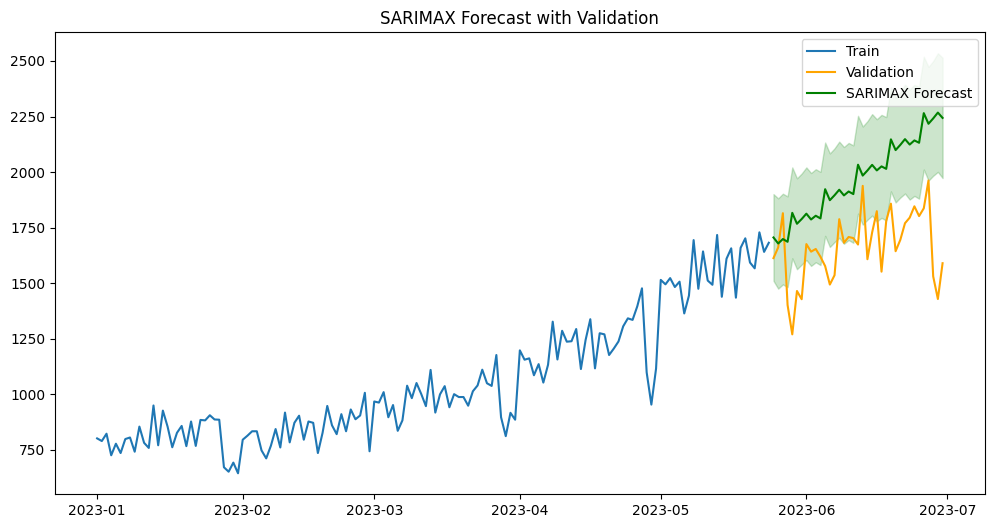

SARIMAX model saved to 'model/sarimax_model.pkl'


In [36]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
import os

# Create /model directory if it doesn't exist
os.makedirs('model', exist_ok=True)


# Aggregate daily sales
ts = df.groupby('transaction_date')['transaction_qty'].sum()

# Train-validation split (last 20% = validation)
split_index = int(len(ts) * 0.8)
train_ts = ts.iloc[:split_index]
val_ts   = ts.iloc[split_index:]

# Fit SARIMAX on training data
model = SARIMAX(train_ts, order=(2,1,2), seasonal_order=(1,1,1,7))
results = model.fit(disp=False)

# Forecast horizon = length of validation
forecast = results.get_forecast(steps=len(val_ts))
y_pred = forecast.predicted_mean
y_true = val_ts.values

# RMSE
rmse_sarimax = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"SARIMAX RMSE: {rmse_sarimax:.3f}")

# Confidence intervals
conf_int = forecast.conf_int()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(train_ts.index, train_ts, label='Train')
plt.plot(val_ts.index, val_ts, label='Validation', color='orange')
plt.plot(val_ts.index, y_pred, label='SARIMAX Forecast', color='green')
plt.fill_between(val_ts.index, conf_int.iloc[:,0], conf_int.iloc[:,1], 
                 color='green', alpha=0.2)
plt.legend()
plt.title("SARIMAX Forecast with Validation")
plt.show()

# Save the in /model directory
results.save('model/sarimax_model.pkl')
print("SARIMAX model saved to 'model/sarimax_model.pkl'")


##  Model Comparison: XGBoost, Prophet, SARIMAX

### RMSE Results
| Model                                | Level              | RMSE    |
|--------------------------------------|--------------------|---------|
| **XGBoost (baseline)**               | Product-level      | 3.19    |
| **XGBoost (with clusters)**          | Product-level      | 3.15    |
| **Prophet (average across products)**| Product-level      | 6.26    |
| **Prophet (aggregate)**              | Total daily sales  | 236.8   |
| **SARIMAX (aggregate)**              | Total daily sales  | 358.4   |

---

###  Interpretation

- **XGBoost (baseline vs clusters)**  
  - Baseline RMSE: **3.19**  
  - With clusters: **3.15**  
  - The inclusion of clusters produced only a **marginal improvement**, confirming that short-term lags and rolling features dominate predictive power.  

- **Prophet**  
  - Performs poorly at product-level (RMSE ~6.26), due to short and noisy individual series.  
  - Performs better at aggregate level (RMSE ~236.8), effectively capturing **trend and weekly seasonality**.  
  - Useful for interpretable long-term, macro-level forecasting.  

- **SARIMAX**  
  - RMSE ~358.4 at aggregate level, worse than Prophet.  
  - Captures some trend and seasonality, but less accurate and less flexible than Prophet on this dataset.  

---

###  Conclusions

- For **product-level forecasting (micro)**:  
  ➝ **XGBoost** is the most accurate model. Clusters add negligible value, while **lag/rolling features are the key drivers** of performance.  

- For **aggregate forecasting (macro)**:  
  ➝ **Prophet** is preferable to SARIMAX, offering clearer trend/seasonality decomposition and better accuracy.  

- **SARIMAX** serves as a useful statistical benchmark but underperforms compared to Prophet in this case.

 **Overall:**  
- Use **XGBoost** when precision at the product level is required.  
- Use **Prophet** when analyzing global sales trends and seasonality at the business level.
